Implementing k-fold cross validation and mini-batch

In [1]:
import json
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import tensorflow as tf
import pprint as pp
import math
import random
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
import pickle
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f)
        
def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
filepath = "../data/student_vectors_n_task_10_n_limit_10000.json"
#filepath2 = "../../../student_vectors_n_task_10_n_limit_100000.json"
student_vectors = json.load(open(filepath))
#student_vectors2 = json.load(open(filepath2))

Stats about data:

Number of unique task IDs: 10
Number of students: 1255


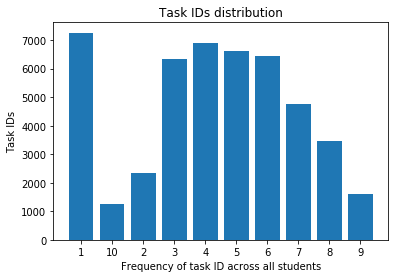

Task IDs mapping: 
Task ID -> p7cfRPp-kQ.partb(1) is attempted 7259 times. Max seq len: 46
Task ID -> Ok-iIHxjgx.partb(2) is attempted 2325 times. Max seq len: 27
Task ID -> 1zsCldT4p8.set1(3) is attempted 6346 times. Max seq len: 39
Task ID -> DebcfZEEmI.proper_fractions(4) is attempted 6897 times. Max seq len: 40
Task ID -> 9wRCzK1G7F.partb(5) is attempted 6632 times. Max seq len: 43
Task ID -> 1zsCldT4p8.set2(6) is attempted 6443 times. Max seq len: 28
Task ID -> nl-M69Ez9k.parta(7) is attempted 4753 times. Max seq len: 56
Task ID -> kvig7fcCVc.partb(8) is attempted 3473 times. Max seq len: 32
Task ID -> Ok-iIHxjgx.parta(9) is attempted 1589 times. Max seq len: 39
Task ID -> hyei4uD81i.parta(10) is attempted 1255 times. Max seq len: 40


In [6]:
task_ids = []
for i in student_vectors:
    for j in student_vectors[i]:
        if j['task_id'] not in task_ids:
            task_ids.append(j['task_id'])
print("Number of unique task IDs: " + str(len(task_ids)))
print("Number of students: " + str(len(student_vectors)))

#frequency distribution of taskids
cnt2 = Counter()
another_2 = {}
seqlen_tasks = {}
temp_seqlen = {}
position_2 = 1
for i in student_vectors:
    for k in temp_seqlen:
        temp_seqlen[k] = 0
    for j in student_vectors[i]:
        if(j['second_try'] == False):
            if j['task_id'] not in another_2:
                another_2[j['task_id']] = str(position_2)
                position_2 = position_2 + 1
            if j['task_id'] not in seqlen_tasks:
                seqlen_tasks[j['task_id']] = []

            if j['task_id'] not in temp_seqlen:
                temp_seqlen[j['task_id']] = 1
            else:
                temp_seqlen[j['task_id']] += 1
            cnt2[another_2[j['task_id']]] += 1
    for k in seqlen_tasks:
        seqlen_tasks[k].append(temp_seqlen[k])
plt.bar(cnt2.keys(), cnt2.values())
plt.title("Task IDs distribution")
plt.xlabel("Frequency of task ID across all students")
plt.ylabel("Task IDs")
plt.show()
print("Task IDs mapping: ")
for i in another_2:
    print("Task ID -> "+str(i)+"("+str(another_2[i])+") is attempted " + str(cnt2[another_2[i]]) + " times." + " Max seq len: "+str(max(seqlen_tasks[i])))

Generating encodings in 'sequences' (x), 'seqlen' (sequence lengths) and 'output_y' (y)

In [75]:
#pre-processing for using MultiLabelBinarizer
temp_ids = []
for i in task_ids:
    temp_ids.append([i])

#generating encodings
enc = MultiLabelBinarizer()
task_ids_1hot = (enc.fit_transform(temp_ids)).astype(float)
task_ids_classes = enc.classes_
task_ids_dict = dict(zip(task_ids, task_ids_1hot))
# print("\n1-hot encoding for task IDs:")
# pp.pprint(task_ids_dict)

sequences = []
output_y = []
seqlen = []
incorrect_tid_vec = np.zeros((len(task_ids)), dtype=np.float)
for i in student_vectors:
    temp_seq = []
    temp_seq.append(np.concatenate([incorrect_tid_vec,incorrect_tid_vec])) #for taking first prediction into account
    for j in student_vectors[i]:
        if(j['second_try'] == False): #ignoring second_try
            if(j['correct'] == True):
                vec = np.concatenate([task_ids_dict[j['task_id']],incorrect_tid_vec])
                temp_seq.append(np.asarray(vec))
            else:
                vec = np.concatenate([incorrect_tid_vec,task_ids_dict[j['task_id']]])
                temp_seq.append(np.asarray(vec))
    if(len(temp_seq)>1):
        seqlen.append(len(temp_seq)-1)
        last_one = temp_seq.pop() #remove last interaction vector
        sequences.append(np.asarray(temp_seq)) #add it to x
        first_one = temp_seq.pop(0) #remove first interaction vector
        temp_seq.append(last_one)
        output_y.append(np.asarray(temp_seq)) #concatenate with last vector, and append to output! 

length_interaction_vector = 2*(len(task_ids)) #length of interaction vector
sequences_lengths1 = [[x] for x in seqlen]
# print("Sample interaction vector: ")
# pp.pprint(sequences[0][0])

Preparing data per skill ID for calculating AUC per skill over epochs.

In [47]:
per_skill = {}
per_skill['x'] = {}
per_skill['y'] = {}
per_skill['seqlen'] = {}
for i in another_2:
    per_skill['x'][i] = []
    per_skill['y'][i] = []
    per_skill['seqlen'][i] = []
    for p in student_vectors:
        interactions = []
        interactions.append(np.concatenate([incorrect_tid_vec,incorrect_tid_vec]))
        for j in student_vectors[p]:
            if(j['task_id'] == i and j['second_try'] == False):
                if(j['correct'] == True):
                    vec = np.concatenate([task_ids_dict[j['task_id']],incorrect_tid_vec])
                    interactions.append(vec)
                else:
                    interactions.append(np.concatenate([incorrect_tid_vec,task_ids_dict[j['task_id']]]))
        if(len(interactions) > 1):
            per_skill['seqlen'][i].append(len(interactions)-1)
            last_one = interactions.pop()
            per_skill['x'][i].append(interactions)
            first_one = interactions.pop(0)
            interactions.append(last_one)
            per_skill['y'][i].append(interactions)

In [40]:
max_seqlen = max(seqlen)
print("Maximum sequence length across the whole dataset = "+str(max_seqlen+1))
training_set_split = 0.8
split = int((training_set_split)*len(student_vectors))
print("Splitting "+str(len(student_vectors))+" rows (or students) into "+str(split)+ " for training and rest for testing.")
BATCH_SIZE = 251
print("Batch Size = "+str(BATCH_SIZE))
num_units = 50
print("Number of recurrent units = "+str(num_units))
learning_tf_rate = 0.1
print("Learning rate = "+str(learning_tf_rate))
display_step = 20
print("display step = "+str(display_step))

Maximum sequence length: 187
Splitting 1255 rows (or students) into 1004 for training and rest for testing.
Batch Size = 251
Number of recurrent units = 50
Learning rate = 0.1
display step = 20


In [39]:
np.set_printoptions(threshold=np.nan)

import math
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def calculate_auc (y_true,y_pred,sequence_lengths=[],plot=False,debug=False):
    if sequence_lengths == []:
        return roc_auc_score(y_true, y_pred)
    else:
        con_y_true = np.zeros([sum(sequence_lengths),length_interaction_vector])
        con_y_pred = np.zeros([sum(sequence_lengths),length_interaction_vector])
        index = 0
        for i in range(len(y_true)): #per student
            for j in range(sequence_lengths[i]): #up to the sequence length
                con_y_true[index] = y_true[i][j]
                con_y_pred[index] = y_pred[i][j]
                index += 1
        con1_y_true = np.zeros([sum(sequence_lengths)])
        con1_y_pred = np.zeros([sum(sequence_lengths)])
        
        for l in range(sum(sequence_lengths)):
            index_one = np.argmax(con_y_true[l])
            if(index_one >= int(length_interaction_vector/2)):
                index_two = index_one - int(length_interaction_vector/2)
            else:
                index_two = index_one
                index_one = index_one + int(length_interaction_vector/2)
            if(np.argmax(con_y_true[l]) == index_one): #true is incorrect
                con1_y_true[l] = 0.
                con1_y_pred[l] = 1.0 - con_y_pred[l][index_one]
            elif(np.argmax(con_y_true[l]) == index_two):
                con1_y_true[l] = 1.
                con1_y_pred[l] = con_y_pred[l][index_two]
        debug=False
        if(debug):
            print(np.c_[con1_y_true,con1_y_pred])
        fpr, tpr, thresholds = roc_curve(con1_y_true, con1_y_pred)
        #print("tpr: "+str(tpr) + ", fpr: "+str(fpr) + ", thresholds: "+str(thresholds))
        if(plot):
            return [roc_auc_score(con1_y_true, con1_y_pred),fpr,tpr]
        else:
            return roc_auc_score(con1_y_true, con1_y_pred)

In [95]:
tf.reset_default_graph()
tf.set_random_seed(1234)

#define placeholders
# x = tf.placeholder(tf.float32, [None, None, length_interaction_vector]) #batch_size, max_seqlen of that batch, inter.v
# y = tf.placeholder(tf.float32, [None, None, length_interaction_vector])
# seqlen_tf = tf.placeholder(tf.float32,[None])

#split the input data into test and train set
train_x, test_x = tf.split(np.asarray(sequences), [split,len(student_vectors) - split], 0)
train_seqlen, test_seqlen = tf.split(seqlen, [split,len(student_vectors) - split], 0)
train_seqlen1, test_seqlen1 = tf.split(sequences_lengths1, [split,len(student_vectors) - split], 0)
train_y, test_y = tf.split(np.asarray(output_y), [split,len(student_vectors) - split], 0)

#making batches
train_x_batch, train_y_batch, train_seqlen_batch,train_seqlen_batch1 = tf.train.batch([train_x, train_y, train_seqlen, train_seqlen1], batch_size = BATCH_SIZE, dynamic_pad = True, allow_smaller_final_batch = True, enqueue_many = True)
#https://www.tensorflow.org/api_docs/python/tf/train/batch 

#Dynamic RNN 
def dynamicRNN(x1, seqlen_tf1):
    rnn_cell = tf.nn.rnn_cell.BasicLSTMCell(num_units,reuse=tf.AUTO_REUSE)
    outputs, states = tf.nn.dynamic_rnn(rnn_cell, x1, dtype=tf.float32,sequence_length= seqlen_tf1)
    out_size = int(length_interaction_vector / 2)
    outputs = tf.contrib.layers.fully_connected(outputs, out_size, activation_fn = tf.nn.sigmoid, weights_initializer=tf.contrib.layers.xavier_initializer(uniform=False))
    opposites = tf.subtract(tf.ones(tf.shape(outputs)),outputs)
    outputs1 = tf.concat([outputs,opposites],2)
    return outputs1

#predictions for training and test set
pred_train = dynamicRNN(train_x_batch, train_seqlen_batch)
pred_train = pred_train * train_y_batch #masking output
pred_test = dynamicRNN(test_x, test_seqlen)
pred_test = pred_test * test_y #masking output
#pred = dynamicRNN(x,seqlen_tf) #for generic evaluation, bypassing split and batching operation
pred_train1 = dynamicRNN(train_x, train_seqlen)
pred_train1 = pred_train1 * train_y #masking output

# Define loss and optimizer
cost1 = tf.nn.sigmoid_cross_entropy_with_logits(logits=pred_train, labels=y)
mask = tf.cast(tf.sequence_mask(lengths=train_seqlen_batch1, maxlen = tf.reduce_max(train_seqlen_batch1)), tf.float32)
cost1 = tf.multiply(cost1,tf.transpose(mask, perm=[0, 2, 1]))
cost1 = tf.reduce_sum(cost1, 1)
cost1 /= tf.cast(train_seqlen_batch,tf.float32)
cost = tf.reduce_mean(cost1)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_tf_rate).minimize(cost)

saver = tf.train.Saver(max_to_keep=5)

TypeError: Expected binary or unicode string, got array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]])

In [90]:
import time

startTime = time.time()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    stop = False
    cost_prev = 1.0
    step = 0
    startTime1 = time.time()
    while(stop==False):
        sess.run(optimizer, feed_dict={x: sequences, y: output_y, seqlen_tf: seqlen})
        step += 1
        if step % display_step == 0 or step == 1:
            print("\t\t Time taken: %f" % (time.time() - startTime1))
            startTime1 = time.time()
            saver.save(sess, 'combined_model_4/model.ckpt',global_step=display_step)
            loss = sess.run(cost, feed_dict={x: sequences, y: output_y, seqlen_tf: seqlen})
            if cost_prev - loss <= 0.00005:
                stop = True
            else:
                cost_prev = loss
            #calculate and report AUCs
            #overall first
            train_seqlen_o, test_seqlen_o, true_train_o, true_test_o, pred_train_o, pred_test_o = sess.run([train_seqlen, test_seqlen, train_y, test_y, pred_train1, pred_test], feed_dict={x: sequences, y: output_y, seqlen_tf: seqlen, condition:0})
            o_train_auc = calculate_auc(true_train_o,pred_train_o,train_seqlen_o)
            o_test_auc = calculate_auc(true_test_o,pred_test_o,test_seqlen_o)
            print("Overall Train AUC: "+str(o_train_auc) + ", test AUC: "+str(o_test_auc))
print("Total Time taken: %f" % (time.time() - startTime))

ValueError: setting an array element with a sequence.

Suggestions for later:
- https://www.tensorflow.org/versions/r1.5/api_docs/python/tf/contrib/learn/DynamicRnnEstimator#evaluate
- we can also do dynamic partition of training and test set: http://ischlag.github.io/2016/06/19/tensorflow-input-pipeline-example/, but to compare with all the other models, I am fixing the test set.
- try using shuffle_batch instead of tf.batch https://www.tensorflow.org/api_docs/python/tf/train/shuffle_batch 
- tried the suggestion, turns out one can't feed inconsistent dimensional tensors via feed_dict. And also, none of the functions (like - tf.train.batch etc. seem to be accepting the original variables). I need to try it on a small notebook first.

In [99]:
np.shape(np.asarray(sequences)[0])

(32, 20)